# The Gini’s Smoke: Effect of Income Inequality on Health Impacts from Air Pollution in Canadian Cities
## 323 Final Project

### Motivation

Air pollution is a major factor impacting health, with effects especially on the respiratory system. Particulates can come from natural sources, such as dust, sand, or smoke from forest fires, but increasingly poor air quality is a result of human behaviour such as driving, power generation, and construction. All of these factors are exasterbaded in highly populated areas such as cities, with some places such as Bejing and Mumbai suffering epidemics of respratory health problems.

Another factor which is known to have wide-ranging health impacts is wealth. In their 2008 study _Does income inequality modify the association between air pollution and health?_, Charafeddine & Boden look at the interaction between wealth inequality and health impacts of air pollution in cities in the United States. 

Charafeddine & Boden hypothesised a positive correlation between income inequality and impacts of air pollution, but in fact found a negative correlation. However, there were a number of limitations in their study. Specifically, they use county-level air quality data as a proxy for the air quality in cities, which may not have a high correlation. Further, they look only at self-reported health, which may be impacted by many factors and be too noisy to show marginal results.

In this report, I continue the work of Charafeddine & Boden by looking at the interaction between the Gini coefficient and health impacts of air pollution in Canadian cities. I improve on their research by looking at city-level air-quality data, rather than county level, and by looking at factors such as asthma and lung cancer rates in addition to self-reported health.

Still, there are important limitations in my data. I am only able to find data for the Gini index from 2020, while my air quality data is from 2018. As wealth demographics change slowly, this should not present an issue. More seriously, my health data is from 2013, as the Log4Shell security vulnerability caused Statistics Canada to take down more recent data during the project period.

With these caveats, I predict that there will be positive interaction between higher wealth inequality and impacts of air pollution.

### Data
To measure wealth inequality, I use the Gini indexes compiled by Xia et al. in _Geographical concentration of COVID-19 cases by social determinants of health in 16 large metropolitan areas in Canada – a cross-sectional study_ in 2020. The Gini index provides a score between 0 and 1, with 0 indicating perfect income equality, and 1 indicating maximum disparity.

For data on air quality, I choose to look at city-level PM2.5 data from the World Health Organization from 2018. PM2.5 indicates the number of particles smaller than 2.5nm per meter cubed of air. There are many components of air quality which impact health, but PM2.5 is considered one of the more important factors, and this is the measure that Charafeddine & Boden chose to use in thier paper.

Finally, for health data, I use the Health Profile compiled by Statistics Canada in 2013. Although more recent data exists, all such data was either accessible only to researchers, or unavailible due to the Log4Shell vulnerability.
The Health Profile still provides much useful data. In addition to self-reported health, I am able to look at rates of lung cancer, asthma, and respritory disease, as well as factors which may bias the results such as smoking.

In [652]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import re

from shapely.geometry import Point, shape, Polygon, MultiPolygon
import fiona

from sklearn import linear_model, metrics

%matplotlib inline

In [41]:
gini_import = pd.read_excel("./Data/gini.xlsx")

In [42]:
homicide_import = pd.read_excel("./Data/Homicide rate.xlsx", skipfooter = 4)

In [43]:
air_quality_import = pd.read_csv("./Data/WHO_air_quality_database_2018_v14_merged.csv")

In [387]:
health_names = ["Hamilton", "Kelowna", "Montreal", "Ottawa", "Quebec", "Saguenay", "Sherbrooke", "Toronto", "Trois-Rivieres", "Vancouver", "Waterloo", "Windsor", "Winnipeg", "Abbotsford"]
health_data_array = {}
selected_rows = ["Perceived health; very good or excellent (%)", "Lung cancer incidence (per 100000 population)", "Current smoker; daily or occasional (%)", "Current smoker; daily (%)", "Leisure-time physical activity; moderately active or active (%)", "Second-hand smoke; exposure at home (%)", "Second-hand smoke; exposure in vehicles and/or public places (%)", "Asthma (%)", "Lung cancer; deaths (per 100000 population)", "Respiratory diseases; deaths (per 100000 population)", "Low income (%)"]
for name in health_names:
    health_data_array[name] = pd.read_csv("./Data/" + name + "2013.csv", header = 1, skipfooter = 13, engine='python', encoding = "latin-1").replace(np.NaN, 0).replace("..", 0)
    health_data_array[name]["Characteristics"] = health_data_array[name]["Characteristics"].str.strip()
    health_data_array[name] = health_data_array[name].loc[health_data_array[name]["Characteristics"].isin(selected_rows)]


In [487]:
air_quality_canada = air_quality_import.loc[air_quality_import["Country"] == "Canada"]
# air_quality = air_quality_canada.loc
gini_import["Census Metropolitan Area "] = gini_import["Census Metropolitan Area "].str.strip()
cities = gini_import["Census Metropolitan Area "]
air_quality_cities = air_quality_canada.loc[air_quality_canada["City"].isin(cities)]
air_quality_cities = air_quality_cities.append(air_quality_canada.loc[air_quality_canada["City"] == "Ottawa"])
air_quality_cities = air_quality_cities.append(air_quality_canada.loc[air_quality_canada["City"] == "Abbotsford"])
air_quality_cities = air_quality_cities.append(air_quality_canada.loc[air_quality_canada["City"] == "Kitchener"])
air_quality_cities = air_quality_cities.append(air_quality_canada.loc[air_quality_canada["City"] == "Montreal"])
air_quality_cities = air_quality_cities.append(air_quality_canada.loc[air_quality_canada["City"] == "Quebec"])
air_quality_cities = air_quality_cities.append(air_quality_canada.loc[air_quality_canada["City"] == "Trois-Rivieres"])
air_quality_cities["Annual mean, ug/m3"] = air_quality_cities["Annual mean, ug/m3"].apply(lambda x: int(re.search("\d+", x)[0]))

### Mapping
Now that I have imported the data, I will display the cities under study in a map. The location data is sourced from Statistics Canada.

In [390]:
cities_df = gpd.read_file("https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/files-fichiers/2016/lcma000b16a_e.zip")
canada_land_df = gpd.read_file("https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/files-fichiers/2016/lpr_000b16a_e.zip")
canada_water_df = gpd.read_file("https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/files-fichiers/2016/lpr_000a16a_e.zip")

In [493]:
cities_df["CMANAME"] = cities_df["CMANAME"].apply(lambda name: name if isinstance(name, str) else name.decode("latin-1"))
cities_df = cities_df.loc[cities_df["CMANAME"].isin(air_quality_cities["City"])]

D:\Program Data\Anaconda3\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
D:\Program Data\Anaconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
D:\Program Data\Anaconda3\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
D:\Program Data\Anaconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.c

[]

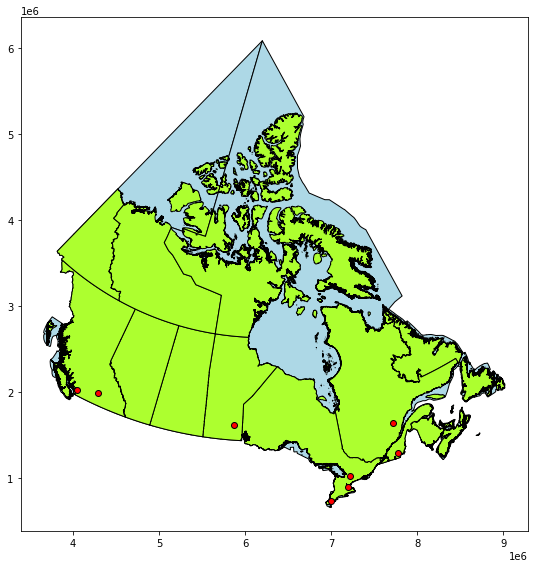

In [494]:
fig, gax = plt.subplots(figsize = (15,8))
canada_water_df.plot(ax = gax, edgecolor = 'black', color = 'lightblue')
canada_land_df.plot(ax = gax, edgecolor = 'black', color = 'greenyellow')
city_points = cities_df.copy()
for name in air_quality_cities["City"]:
    city_row = cities_df.loc[cities_df["CMANAME"] == name]
    if len(city_row) == 0:
        continue
    city_index = list(city_row.index)[0]
    city_shape = cities_df.loc[city_index]["geometry"]
    poly = ""
    if isinstance(city_shape, Polygon):
        poly = city_shape
    else:
        poly = list(city_shape)[0]
    x, y = poly.exterior.coords.xy
    city_points["geometry"].at[city_index] = Point(x[0], y[0])
# display(city_pointsf)
city_points.plot(ax = gax, edgecolor = 'black', color = 'red')
    
plt.plot()

### Analysis
With data imported, I now perform analysis. 

In [488]:
aq_vs_health = air_quality_cities["City"].copy().to_frame().join(air_quality_cities["Annual mean, ug/m3"].copy())
aq_vs_health = aq_vs_health.set_index("City")
aq_vs_health = aq_vs_health.rename(index={"Kitchener": "Waterloo"})
for col in selected_rows:
    col = col.strip()
    aq_vs_health[col] = pd.Series(dtype = "float64")
for name, df in health_data_array.items():
    for col in selected_rows:
        col = col.strip()
        aq_vs_health[col].at[name] = list(df.loc[df["Characteristics"] == col, "Total"])[0]
#         print(list(df.loc[df["Characteristics"] == col, "Total"])[0])
# list(health_data_array["Toronto"].loc[health_data_array["Toronto"]["Characteristics"] == "Perceived health; very good or excellent (%)"]["Total"])[0]


In [560]:
def abline(slope, intercept, color):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color = color)
    
def plot_scatter(x_text, y_text, color = '#1f77b4', trend_color = 'r', df = aq_vs_health, ax = None):
    x_list = list(df[x_text])
    y_list = list(df[y_text])
    intercept, slope = np.polynomial.polynomial.polyfit(x_list, y_list, 1)
    ax = df.plot.scatter(x = x_text, y = y_text, color = color, ax = ax)
    abline(slope, intercept, trend_color)
    return ax

I first look at the relationship between PM2.5 pollution and health using a simple scatter plot with a trend line. This shows us the general relationship between air quality and health for all cities. It is expected that there will be a negative trend found for perceved health, and a positive trend found for rates of respritory illness.

<AxesSubplot:xlabel='Annual mean, ug/m3', ylabel='Asthma (%)'>

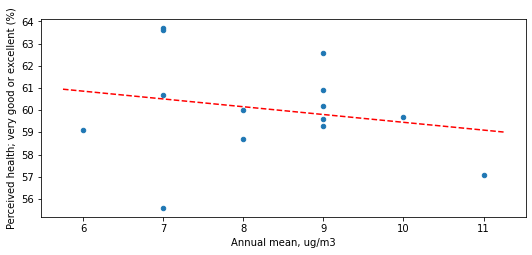

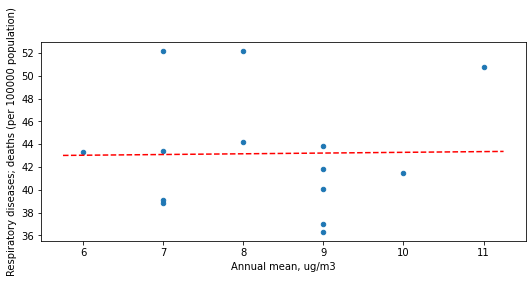

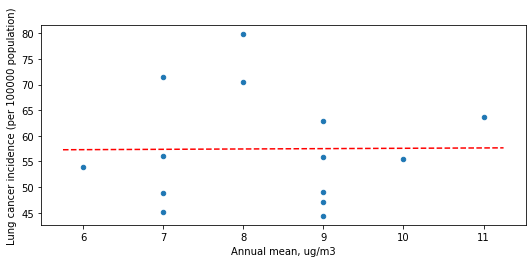

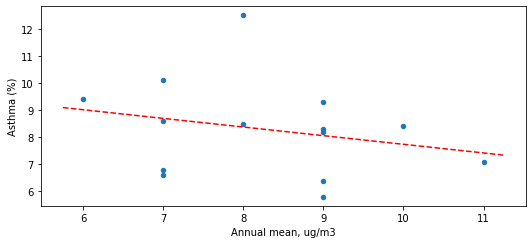

In [561]:
plot_scatter("Annual mean, ug/m3", "Perceived health; very good or excellent (%)")
plot_scatter("Annual mean, ug/m3", "Respiratory diseases; deaths (per 100000 population)")
plot_scatter("Annual mean, ug/m3", "Lung cancer incidence (per 100000 population)")
plot_scatter("Annual mean, ug/m3", "Asthma (%)")

There is a negative trend between air quality and health, but it is weak. There is little correlation between air quality and respritory disease or lung cancer, and a negative correlation between air quality and asthma. This is surprising, and does not agree with my expectations.

Next, I use the same technique to look at the effect of smoking. This will give an indication of the relative importance of smoking versus air pollution. I expect a negative correlation between smoking and health, and a positive correlation between smoking and respritory illness.

<AxesSubplot:xlabel='Current smoker; daily or occasional (%)', ylabel='Asthma (%)'>

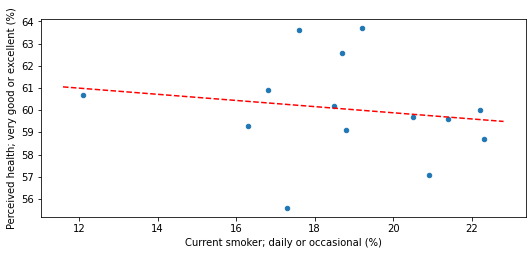

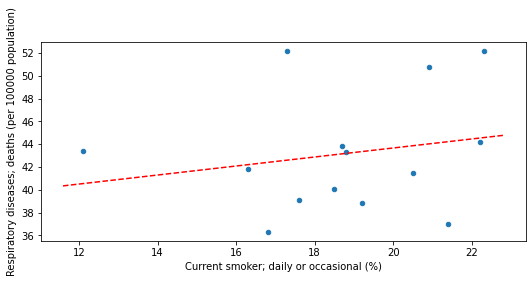

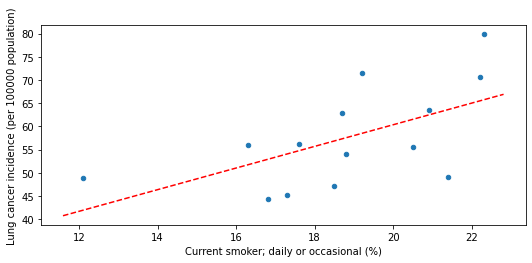

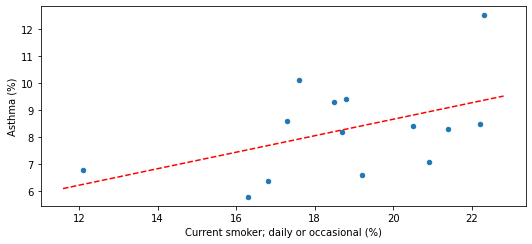

In [562]:
plot_scatter("Current smoker; daily or occasional (%)", "Perceived health; very good or excellent (%)")
plot_scatter("Current smoker; daily or occasional (%)", "Respiratory diseases; deaths (per 100000 population)")
plot_scatter("Current smoker; daily or occasional (%)", "Lung cancer incidence (per 100000 population)")
plot_scatter("Current smoker; daily or occasional (%)", "Asthma (%)")

In this case, the results are much more clear, and agree with my expectation. This suggests that smoking is much more important for respritory health at a municipal level than air quality, or possibly that there is a fundamental incompatibility between the data from 2013 and 2018.

Now, I turn to the interaction due to income inequality

In [557]:
gini_cities = gini_import.set_index("Census Metropolitan Area ")
gini_cities = gini_cities.rename(index={"Abbotsford-Mission": "Abbotsford", "Ottawa-Gatineau (Ontario part)": "Ottawa", "Kitchener-Cambridge-Waterloo": "Waterloo", "Montréal": "Montreal", "Québec City": "Quebec", "Trois-Rivières": "Trois-Rivieres"})
gini_cities = gini_cities.drop("St. Catharines-Niagara").drop("Ottawa-Gatineau (Québec part)")
gini_cities = gini_cities.sort_values('Gini', ascending = True)

If there is no interaction between income inequality and the effect of air quality on health, it is expected that any subgroup of cities would show the same trendline between air quality and health as the total group. If there is an interaction, then grouping the cities by levels of income inequality and creating a scatter plot should show a different trend line depending on the group. In this case, I expect the trend line to be steeper (positive or negative, depending on the y-axis) for cities with Gini coefficients closer to 1.

<AxesSubplot:xlabel='Census Metropolitan Area '>

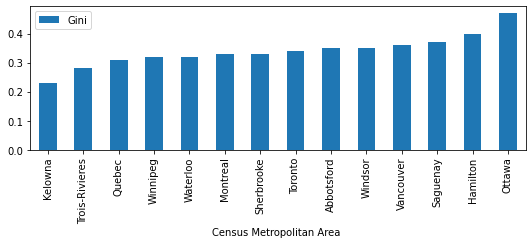

In [558]:
gini_cities.plot.bar()

The Gini coefficients follow an S-curve, so there is no clear boundry with which to group the data. I choose groups as follows, although others may make different choices:

| Group   | Gini <  |
|---------|---------|
| Lowest  | 0.3     |
| Lower   | 0.35    |
| Higher  | 0.4     |
| Highest | 0.5     |

Text(0, 0.5, 'Gini')

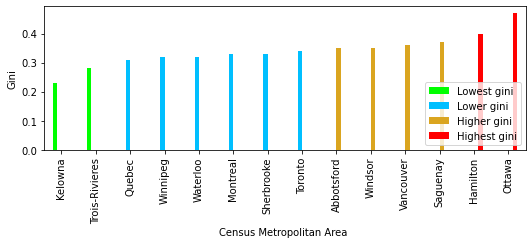

In [590]:
lowest_gini = 0.3
lower_gini = 0.35
higher_gini = 0.4
highest_gini = 0.5

gini_grouped = gini_cities.copy()
gini_grouped["Lowest gini"] = 0
gini_grouped["Lower gini"] = 0
gini_grouped["Higher gini"] = 0
gini_grouped["Highest gini"] = 0

for city in gini_cities.index:
    if gini_cities["Gini"].at[city] < lowest_gini:
        gini_grouped["Lowest gini"].at[city] = gini_cities["Gini"].at[city]
    elif gini_cities["Gini"].at[city] < lower_gini:
        gini_grouped["Lower gini"].at[city] = gini_cities["Gini"].at[city]
    elif gini_cities["Gini"].at[city] < higher_gini:
        gini_grouped["Higher gini"].at[city] = gini_cities["Gini"].at[city]
    elif gini_cities["Gini"].at[city] < highest_gini:
        gini_grouped["Highest gini"].at[city] = gini_cities["Gini"].at[city]

gini_grouped = gini_grouped.drop("Gini", axis = 1)
gini_grouped.plot.bar(color = ["lime", "deepskyblue", "goldenrod", 'r'])
plt.legend( loc = 'lower right')
plt.ylabel("Gini")

In [549]:
aq_vs_health["Lowest gini"] = 0
aq_vs_health["Lower gini"] = 0
aq_vs_health["Higher gini"] = 0
aq_vs_health["Highest gini"] = 0

for city in gini_cities.index:
    if gini_cities["Gini"].at[city] < lowest_gini:
        aq_vs_health["Lowest gini"].at[city] = 1
    elif gini_cities["Gini"].at[city] < lower_gini:
        aq_vs_health["Lower gini"].at[city] = 1
    elif gini_cities["Gini"].at[city] < higher_gini:
        aq_vs_health["Higher gini"].at[city] = 1
    elif gini_cities["Gini"].at[city] < highest_gini:
        aq_vs_health["Highest gini"].at[city] = 1

aq_vs_health

,"Annual mean, ug/m3",Perceived health; very good or excellent (%),Lung cancer incidence (per 100000 population),Current smoker; daily or occasional (%),Current smoker; daily (%),Leisure-time physical activity; moderately active or active (%),Second-hand smoke; exposure at home (%),Second-hand smoke; exposure in vehicles and/or public places (%),Asthma (%),Lung cancer; deaths (per 100000 population),Respiratory diseases; deaths (per 100000 population),Low income (%),Lowest gini,Lower gini,Higher gini,Highest gini
City,,,,,,,,,,,,,,,,
Hamilton,10,59.7,55.5,20.5,16.9,57.5,4.8,15.6,8.4,42.7,41.5,15.7,0,0,0,1
Kelowna,9,60.2,47.1,18.5,14.6,67.5,0.0,10.9,9.3,38.5,40.1,13.4,1,0,0,0
Saguenay,8,58.7,79.8,22.3,16.8,52.6,8.3,17.3,12.5,57.9,52.2,12.7,0,0,1,0
Sherbrooke,7,63.7,71.4,19.2,16.3,51.3,6.5,12.7,6.6,53.1,38.8,16.2,0,1,0,0
Toronto,9,60.9,44.4,16.8,11.8,49.2,4.1,15.9,6.4,31.7,36.3,17.7,0,1,0,0
Vancouver,7,60.7,48.9,12.1,7.9,57.2,2.1,16.8,6.8,35.7,43.4,20.3,0,0,1,0
Windsor,9,59.3,55.9,16.3,11.5,51.8,5.4,19.1,5.8,44.5,41.8,17.0,0,0,1,0
Winnipeg,6,59.1,54.0,18.8,12.9,56.6,4.1,19.2,9.4,43.9,43.3,18.1,0,1,0,0
Ottawa,7,63.6,56.1,17.6,12.6,60.4,4.5,22.5,10.1,45.3,39.1,13.5,0,0,0,1


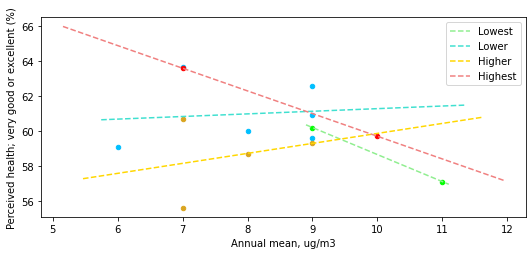

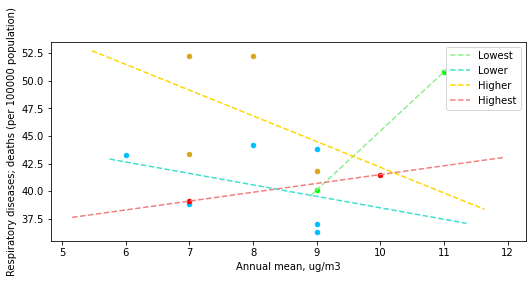

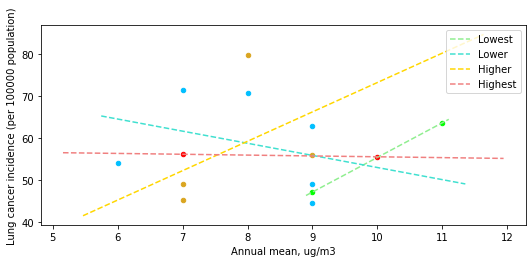

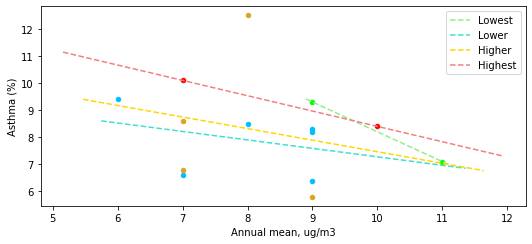

In [591]:
# Perceved health
ax = plot_scatter("Annual mean, ug/m3", "Perceived health; very good or excellent (%)", color = 'lime', trend_color = "lightgreen", df = aq_vs_health.loc[aq_vs_health["Lowest gini"] == 1])
ax = plot_scatter("Annual mean, ug/m3", "Perceived health; very good or excellent (%)", color = 'deepskyblue', trend_color = "turquoise", df = aq_vs_health.loc[aq_vs_health["Lower gini"] == 1], ax = ax)
ax = plot_scatter("Annual mean, ug/m3", "Perceived health; very good or excellent (%)", color = 'goldenrod', trend_color = "gold", df = aq_vs_health.loc[aq_vs_health["Higher gini"] == 1], ax = ax)
ax = plot_scatter("Annual mean, ug/m3", "Perceived health; very good or excellent (%)", color = 'r', trend_color = "lightcoral", df = aq_vs_health.loc[aq_vs_health["Highest gini"] == 1], ax = ax)
plt.legend(["Lowest", "Lower", "Higher", "Highest"], loc = 'upper right')

# Respiratory diseases; deaths (per 100000 population)
ax = plot_scatter("Annual mean, ug/m3", "Respiratory diseases; deaths (per 100000 population)", color = 'lime', trend_color = "lightgreen", df = aq_vs_health.loc[aq_vs_health["Lowest gini"] == 1])
ax = plot_scatter("Annual mean, ug/m3", "Respiratory diseases; deaths (per 100000 population)", color = 'deepskyblue', trend_color = "turquoise", df = aq_vs_health.loc[aq_vs_health["Lower gini"] == 1], ax = ax)
ax = plot_scatter("Annual mean, ug/m3", "Respiratory diseases; deaths (per 100000 population)", color = 'goldenrod', trend_color = "gold", df = aq_vs_health.loc[aq_vs_health["Higher gini"] == 1], ax = ax)
ax = plot_scatter("Annual mean, ug/m3", "Respiratory diseases; deaths (per 100000 population)", color = 'r', trend_color = "lightcoral", df = aq_vs_health.loc[aq_vs_health["Highest gini"] == 1], ax = ax)
plt.legend(["Lowest", "Lower", "Higher", "Highest"], loc = 'upper right')

# Lung cancer incidence (per 100000 population)
ax = plot_scatter("Annual mean, ug/m3", "Lung cancer incidence (per 100000 population)", color = 'lime', trend_color = "lightgreen", df = aq_vs_health.loc[aq_vs_health["Lowest gini"] == 1])
ax = plot_scatter("Annual mean, ug/m3", "Lung cancer incidence (per 100000 population)", color = 'deepskyblue', trend_color = "turquoise", df = aq_vs_health.loc[aq_vs_health["Lower gini"] == 1], ax = ax)
ax = plot_scatter("Annual mean, ug/m3", "Lung cancer incidence (per 100000 population)", color = 'goldenrod', trend_color = "gold", df = aq_vs_health.loc[aq_vs_health["Higher gini"] == 1], ax = ax)
ax = plot_scatter("Annual mean, ug/m3", "Lung cancer incidence (per 100000 population)", color = 'r', trend_color = "lightcoral", df = aq_vs_health.loc[aq_vs_health["Highest gini"] == 1], ax = ax)
plt.legend(["Lowest", "Lower", "Higher", "Highest"], loc = 'upper right')

# Asthma (%)
ax = plot_scatter("Annual mean, ug/m3", "Asthma (%)", color = 'lime', trend_color = "lightgreen", df = aq_vs_health.loc[aq_vs_health["Lowest gini"] == 1])
ax = plot_scatter("Annual mean, ug/m3", "Asthma (%)", color = 'deepskyblue', trend_color = "turquoise", df = aq_vs_health.loc[aq_vs_health["Lower gini"] == 1], ax = ax)
ax = plot_scatter("Annual mean, ug/m3", "Asthma (%)", color = 'goldenrod', trend_color = "gold", df = aq_vs_health.loc[aq_vs_health["Higher gini"] == 1], ax = ax)
ax = plot_scatter("Annual mean, ug/m3", "Asthma (%)", color = 'r', trend_color = "lightcoral", df = aq_vs_health.loc[aq_vs_health["Highest gini"] == 1], ax = ax)
plt.legend(["Lowest", "Lower", "Higher", "Highest"], loc = 'upper right')

Interestingly, the Higher Gini group trendline is consistently steeper than the lower Gini group, suggesting that there is a positive interaction between inequality and the effects of air pollution on health. However, the Lowest Gini and Highest Gini trendlines appear to be almost random, which is to be expected with a group size of 2.

Finally, I perform a linear regression on the data to determine the relative importance of various factors in predicting health outcomes. I choose linear regression as a tool because it works well with small amounts of data, and the results have a relatively clear interpretation. I choose linear regression rather than lasso because I want to see the contribution of all factors, not just major factors.

In [697]:
numeric_columns = ["Annual mean, ug/m3", "Perceived health; very good or excellent (%)", "Lung cancer incidence (per 100000 population)", \
                   "Current smoker; daily or occasional (%)", "Current smoker; daily (%)", "Leisure-time physical activity; moderately active or active (%)", \
                  "Second-hand smoke; exposure at home (%)", "Second-hand smoke; exposure in vehicles and/or public places (%)", "Asthma (%)", \
                   "Lung cancer; deaths (per 100000 population)", "Respiratory diseases; deaths (per 100000 population)", "Low income (%)"]
aq_vs_health_norm = aq_vs_health.copy()
for column_name in numeric_columns:
    aq_vs_health_norm[column_name] = (aq_vs_health[column_name]-aq_vs_health[column_name].min())/(aq_vs_health[column_name].max()-aq_vs_health[column_name].min())

aq_vs_health_norm = aq_vs_health_norm.reset_index()
train = aq_vs_health_norm.sample(frac = 0.75,random_state = 111) 
test = aq_vs_health_norm.drop(train.index)

In [698]:
def train_model(X_list, y_name):
    X = aq_vs_health_norm[X_list]
    y = aq_vs_health_norm[y_name]

    y_train = y[train.index]
    X_train = X.loc[train.index]
    y_test = y[test.index]
    X_test = X.loc[test.index]
    
    lr_model = linear_model.LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_coefs = pd.Series(lr_model.coef_, X.columns)
    
    y_pred = lr_model.predict(X_test)
    mse = metrics.mean_squared_error(y_test, y_pred)
    
    return (lr_coefs, mse)

D:\Program Data\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


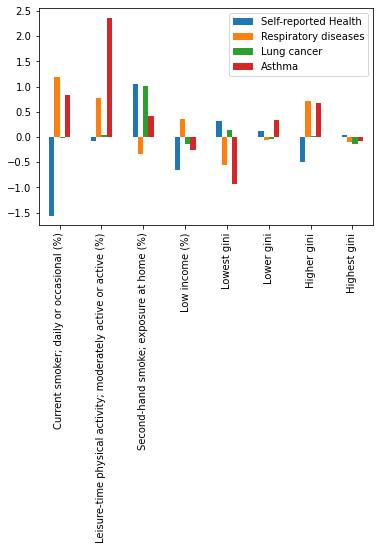

,Self-reported Health,Respiratory diseases,Lung cancer,Asthma
Current smoker; daily or occasional (%),-1.558621,1.181897,-0.014488,0.837881
Leisure-time physical activity; moderately active or active (%),-0.074627,0.777110,0.047526,2.365241
Second-hand smoke; exposure at home (%),1.060379,-0.344603,1.020787,0.409955
Low income (%),-0.658552,0.362609,-0.143660,-0.267529
Lowest gini,0.326612,-0.556344,0.145197,-0.933175
Lower gini,0.110562,-0.055632,-0.029369,0.341766
Higher gini,-0.487077,0.716150,0.022982,0.677705
Highest gini,0.049904,-0.104174,-0.138811,-0.086296
MSE,0.085832,0.371485,0.030068,0.598823


In [699]:
X_list = ["Current smoker; daily or occasional (%)", "Leisure-time physical activity; moderately active or active (%)", "Second-hand smoke; exposure at home (%)", "Low income (%)", "Lowest gini", "Lower gini", "Higher gini", "Highest gini"]

# Health
y_name = "Perceived health; very good or excellent (%)"
health_coefs, health_mse = train_model(X_list, y_name)
health_coefs["MSE"] = health_mse

# Respiratory disease
y_name = "Respiratory diseases; deaths (per 100000 population)"
resp_coefs, resp_mse = train_model(X_list, y_name)
resp_coefs["MSE"] = resp_mse

# Lung cancer
y_name = "Lung cancer incidence (per 100000 population)"
lung_coefs, lung_mse = train_model(X_list, y_name)
lung_coefs["MSE"] = lung_mse

# Asthma
y_name = "Asthma (%)"
asthma_coefs, asthma_mse = train_model(X_list, y_name)
asthma_coefs["MSE"] = asthma_mse

results = health_coefs.to_frame().rename(columns = {0: "Self-reported Health"})
results = results.join(resp_coefs.to_frame()).rename(columns = {0: "Respiratory diseases"})
results = results.join(lung_coefs.to_frame()).rename(columns = {0: "Lung cancer"})
results = results.join(asthma_coefs.to_frame()).rename(columns = {0: "Asthma"})
ax = results.loc[X_list].plot.bar()
plt.legend(bbox_to_anchor=(1,1), bbox_transform = ax.transAxes)
plt.show()
display(results)